In [1]:
import numpy as np
import tensorflow as tf
import keras

In [2]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

83683744/83683744 [==============================] - 3s 0us/step


In [3]:
base_model.trainable = False

In [4]:
inputs = keras.Input(shape=(256, 256, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(5)(x)
model = keras.Model(inputs, outputs)

In [6]:
import os
import random
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define the directory containing all the images
all_data_dir = r"C:\Users\Trenton\Documents\GitHub\Crops-Capstone-3\all_images"

# Define the directory where you want to save the split data
output_dir = r"C:\Users\Trenton\Documents\GitHub\Crops-Capstone-3\split_data"

# Define the image dimensions and batch size
img_width, img_height = 256, 256
batch_size = 32

# Initialize a directory structure for training, validation, and testing
train_dir = os.path.join(output_dir, 'train')
validation_dir = os.path.join(output_dir, 'validation')
test_dir = os.path.join(output_dir, 'test')

# Create class subdirectories within the training, validation, and test directories
for class_folder in os.listdir(all_data_dir):
    class_path = os.path.join(all_data_dir, class_folder)
    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(validation_dir, class_folder), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

# Collect image files for each class
class_image_files = {}
for class_folder in os.listdir(all_data_dir):
    class_path = os.path.join(all_data_dir, class_folder)
    if os.path.isdir(class_path):
        class_image_files[class_folder] = [os.path.join(class_path, filename) for filename in os.listdir(class_path) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif'))]

# Shuffle and split images for each class
for class_folder, image_files in class_image_files.items():
    random.shuffle(image_files)
    num_train = int(len(image_files) * 0.6)
    num_validation = int(len(image_files) * 0.2)
    num_test = len(image_files) - num_train - num_validation

    # Copy images to the respective directories
    for i in range(num_train):
        shutil.copy(image_files[i], os.path.join(train_dir, class_folder))
    for i in range(num_train, num_train + num_validation):
        shutil.copy(image_files[i], os.path.join(validation_dir, class_folder))
    for i in range(num_train + num_validation, num_train + num_validation + num_test):
        shutil.copy(image_files[i], os.path.join(test_dir, class_folder))

# Create data generators for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

validation_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
)



Found 175 images belonging to 5 classes.
Found 56 images belonging to 5 classes.
Found 65 images belonging to 5 classes.


In [8]:
from keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall, F1Score

In [9]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()],
             )
model.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
6/6 [==============================] - 16s 3s/step - loss: 1.6058 - categorical_accuracy: 0.2514 - val_loss: 1.5864 - val_categorical_accuracy: 0.3571
Epoch 2/20
6/6 [==============================] - 13s 2s/step - loss: 1.4671 - categorical_accuracy: 0.4057 - val_loss: 1.4831 - val_categorical_accuracy: 0.4107
Epoch 3/20
6/6 [==============================] - 14s 3s/step - loss: 1.3441 - categorical_accuracy: 0.4857 - val_loss: 1.4371 - val_categorical_accuracy: 0.3750
Epoch 4/20
6/6 [==============================] - 14s 2s/step - loss: 1.3089 - categorical_accuracy: 0.5657 - val_loss: 1.3729 - val_categorical_accuracy: 0.4107
Epoch 5/20
6/6 [==============================] - 14s 2s/step - loss: 1.2173 - categorical_accuracy: 0.5943 - val_loss: 1.3279 - val_categorical_accuracy: 0.5179
Epoch 6/20
6/6 [==============================] - 14s 2s/step - loss: 1.1385 - categorical_accuracy: 0.6171 - val_loss: 1.2850 - val_categorical_accuracy: 0.5536
Epoch 7/20
6/6 [============

In [10]:
evaluation_results = model.evaluate(test_generator)

3/3 [==============================] - 4s 896ms/step - loss: 1.1933 - categorical_accuracy: 0.5846


In [11]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
6/6 [==============================] - 59s 8s/step - loss: 0.7640 - categorical_accuracy: 0.7657 - val_loss: 0.9156 - val_categorical_accuracy: 0.6250
Epoch 2/10
6/6 [==============================] - 48s 8s/step - loss: 0.6578 - categorical_accuracy: 0.8000 - val_loss: 0.8241 - val_categorical_accuracy: 0.6607
Epoch 3/10
6/6 [==============================] - 49s 8s/step - loss: 0.5076 - categorical_accuracy: 0.8514 - val_loss: 0.7841 - val_categorical_accuracy: 0.6607
Epoch 4/10
6/6 [==============================] - 48s 8s/step - loss: 0.4827 - categorical_accuracy: 0.8457 - val_loss: 0.7415 - val_categorical_accuracy: 0.7143
Epoch 5/10
6/6 [==============================] - 48s 8s/step - loss: 0.4018 - categorical_accuracy: 0.8971 - val_loss: 0.6845 - val_categorical_accuracy: 0.7500
Epoch 6/10
6/6 [==============================] - 50s 8s/step - loss: 0.3483 - categorical_accuracy: 0.9200 - val_loss: 0.6455 - val_categorical_accuracy: 0.7857
Epoch 7/10
6/6 [============

In [12]:
evaluation_results = model.evaluate(test_generator)

3/3 [==============================] - 4s 925ms/step - loss: 0.9966 - categorical_accuracy: 0.6615


3/3 [==============================] - 4s 898ms/step
Predicted: wheat Actual: jute
Image: jute\jute002a.jpeg


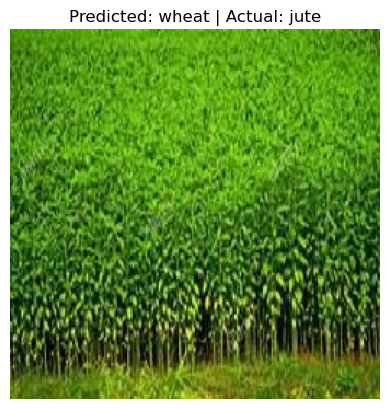

Predicted: sugarcane Actual: jute
Image: jute\jute004a.jpeg


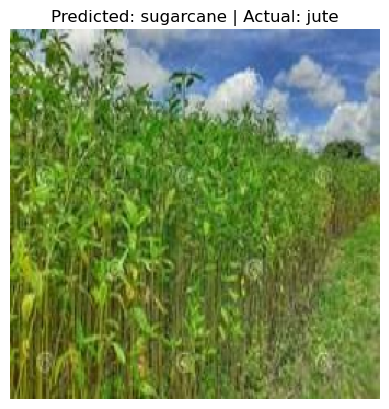

Predicted: sugarcane Actual: jute
Image: jute\jute012a.jpeg


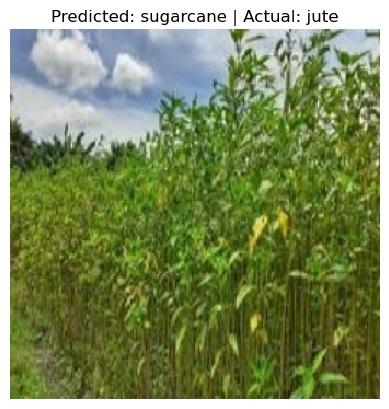

Predicted: rice Actual: jute
Image: jute\jute020a.jpeg


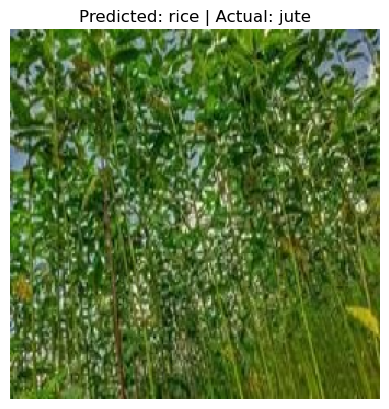

Predicted: sugarcane Actual: jute
Image: jute\jute023a.jpeg


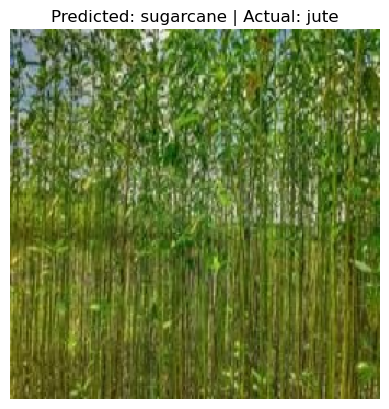

Predicted: wheat Actual: jute
Image: jute\jute024a.jpeg


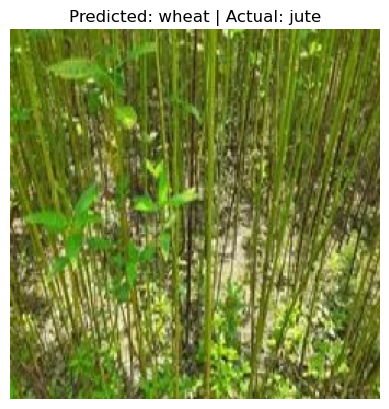

Predicted: wheat Actual: jute
Image: jute\jute032a.jpeg


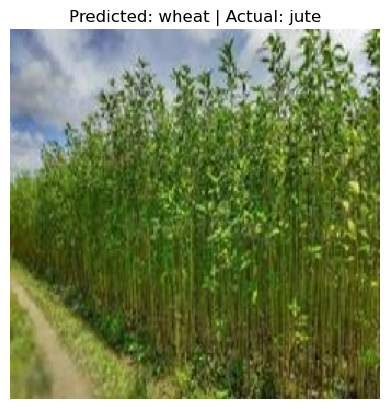

Predicted: wheat Actual: jute
Image: jute\jute035a.jpeg


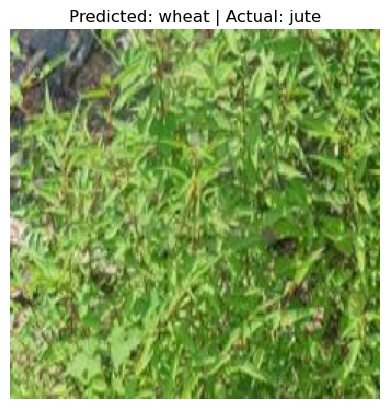

Predicted: rice Actual: jute
Image: jute\jute043a.jpg


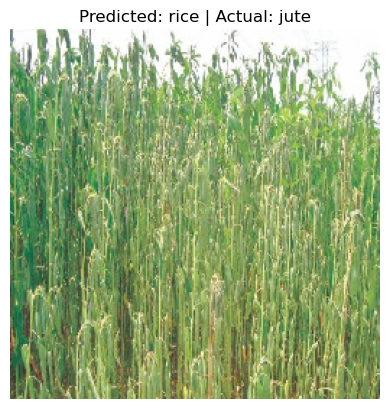

Predicted: rice Actual: maize
Image: maize\maize-field.jpg


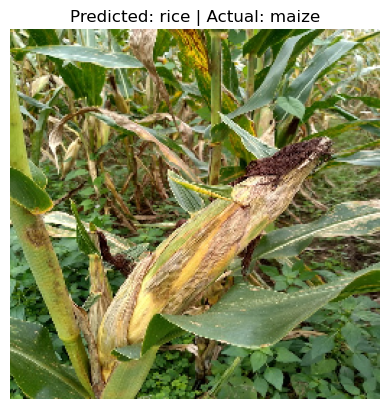

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Predict on test data
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)  # Convert softmax outputs to class labels
true_labels = test_generator.classes  # True class labels from the generator
filenames = test_generator.filenames  # File names of the images

# Find indices of misclassified examples
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Display some misclassified examples
num_examples_to_display = 10
for index in misclassified_indices[:num_examples_to_display]:
    print("Predicted:", class_labels[predicted_labels[index]], "Actual:", class_labels[true_labels[index]])
    print("Image:", filenames[index])

    # Load and display the image
    img_path = os.path.join(all_data_dir, filenames[index])  # Use all_data_dir to access the images
    img = image.load_img(img_path, target_size=(img_width, img_height))
    plt.imshow(img)
    plt.title("Predicted: " + class_labels[predicted_labels[index]] + " | Actual: " + class_labels[true_labels[index]])
    plt.axis('off')
    plt.show()

